todo:
- extract patches and save pngs to output patches dir

In [25]:
# Thanks to Jonathan Mulholland and Aaron Sander from Booz Allen Hamilton
# who made this code public as a part of the Kaggle Data Science Bowl 2017 contest.
# https://www.kaggle.com/c/data-science-bowl-2017/details/tutorial

import SimpleITK as sitk
import numpy as np
import os
from glob import glob
import pandas as pd
from tqdm import tqdm 
import os
from scipy.misc import imsave
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
DATA_DIR = input() #input LUNA16 directory given from $pwd

/home/kyle/datasets/luna16_DATA/


In [5]:
SUBSET_DIR = DATA_DIR + input() #dir where subset yu want to use (e.g. subset2)

subset-sample/


In [6]:
PATCH_DIR = DATA_DIR + input() #where to save patch .pngs

patches/


In [8]:
# List out gobal dir paths
print("{}\n{}\n{}".format(DATA_DIR, SUBSET_DIR, PATCH_DIR))

/home/kyle/datasets/luna16_DATA/
/home/kyle/datasets/luna16_DATA/subset-sample/
/home/kyle/datasets/luna16_DATA/patches/


In [32]:
tuple([32])*3

(32, 32, 32)

In [23]:
# Define global vars
FILE_LIST = glob(SUBSET_DIR + "*.mhd") #list of .mhd img files
MASK_DIMS = (32,32,32) # width, height, depth

In [10]:
def make_mask(center,diam,z,width,height,depth,spacing,origin,
              mask_width=MASK_DIMS[0],mask_height=MASK_DIMS[1],mask_depth=MASK_DIMS[2]):
    """
    Center : centers of circles px -- list of coordinates x,y,z
    diam : diameters of circles px -- diameter
    z = z position of slice in world coordinates mm
    width X height : pixel dim of image
    spacing = mm/px conversion rate np array x,y,z
    origin = x,y,z mm np.array
    """
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    mask_pad = 5
    
    # Defining the voxel range in which the nodule falls
    v_center = (center - origin) / spacing
    v_diam = int(diam / spacing[0] + mask_pad)
    v_xmin = np.max([0,int(v_center[0] - v_diam) - mask_pad])
    v_xmax = np.min([width - 1,int(v_center[0] + v_diam) + mask_pad])
    v_ymin = np.max([0,int(v_center[1] - v_diam) - mask_pad]) 
    v_ymax = np.min([height - 1,int(v_center[1] + v_diam) + mask_pad])

    v_xrange = range(v_xmin,v_xmax + 1)
    v_yrange = range(v_ymin,v_ymax + 1)

    # Convert back to world coordinates for distance calculation
    x_data = [x * spacing[0] + origin[0] for x in range(width)]
    y_data = [x * spacing[1] + origin[1] for x in range(height)]
    
    # SPHERICAL MASK
    # Fill in 1 within sphere around nodule 
#     for v_x in v_xrange:
#         for v_y in v_yrange:
#             p_x = spacing[0]*v_x + origin[0]
#             p_y = spacing[1]*v_y + origin[1]
#             if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
#                 mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
               
    # RECTANGULAR MASK
    for v_x in v_xrange:
        for v_y in v_yrange:
            
            p_x = spacing[0] * v_x + origin[0]
            p_y = spacing[1] * v_y + origin[1]
            
            if ((p_x >= (center[0] - mask_width)) &
                (p_x <= (center[0] + mask_width)) & 
                (p_y >= (center[1] - mask_height)) &
                (p_y <= (center[1] + mask_height))):
                
                mask[int((np.abs(p_y-origin[1]))/spacing[1]),int((np.abs(p_x-origin[0]))/spacing[0])] = 1.0
            
    
    # TODO:  The height and width seemed to be switched. 
    # This works but needs to be simplified. It's probably due to SimpleITK versus Numpy transposed indicies.
    left = np.max([0, np.abs(center[0] - origin[0]) - mask_width]).astype(int)
    right = np.min([width, np.abs(center[0] - origin[0]) + mask_width]).astype(int)
    down = np.max([0, np.abs(center[1] - origin[1]) - mask_height]).astype(int)
    up = np.min([height, np.abs(center[1] - origin[1]) + mask_height]).astype(int)
    
    top = np.min([depth, np.abs(center[2] - origin[2]) + mask_depth]).astype(int)
    bottom = np.max([0, np.abs(center[2] - origin[2]) - mask_depth]).astype(int)
    
    bbox = [[down, up], [left, right], [bottom, top]]
    
    return mask, bbox

In [18]:
# The locations of the nodes
df_node = pd.read_csv(DATA_DIR + "csv-files/candidates_V2.csv")
df_node.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [19]:
def normalizePlanes(npzarray):
    """
    Normalize pixel depth into Hounsfield units (HU), between -1000 - 400 HU
    All other HU will be masked. Then we normalize pixel values between 0 and 1.
    """     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    
    return npzarray

In [20]:
def normalize_img(img):
    """
    Sets the MHD image to be approximately 1.0 mm voxel size
    https://itk.org/ITKExamples/src/Filtering/ImageGrid/ResampleAnImage/Documentation.html
    """
    new_x_size = int(img.GetSpacing()[0]*img.GetWidth())  # Number of pixels you want for x dimension
    new_y_size = int(img.GetSpacing()[1]*img.GetHeight()) # Number of pixels you want for y dimension
    new_z_size = int(img.GetSpacing()[2]*img.GetDepth())  # Number of pixels you want for z dimesion
    new_size = [new_x_size, new_y_size, new_z_size]
    
#     new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(img.GetSize(), img.GetSpacing(), new_size)]

    new_spacing = [1,1,1]  # New spacing to be 1.0 x 1.0 x 1.0 mm voxel size
    interpolator_type = sitk.sitkLinear

    return sitk.Resample(img, np.array(new_size, dtype='uint32').tolist(), sitk.Transform(), interpolator_type, img.GetOrigin(), new_spacing, img.GetDirection(), 0.0, img.GetPixelIDValue())
    


  0%|          | 0/8 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/kyle/anaconda2/envs/tensorflow-3x/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kyle/anaconda2/envs/tensorflow-3x/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kyle/anaconda2/envs/tensorflow-3x/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
Class = 1


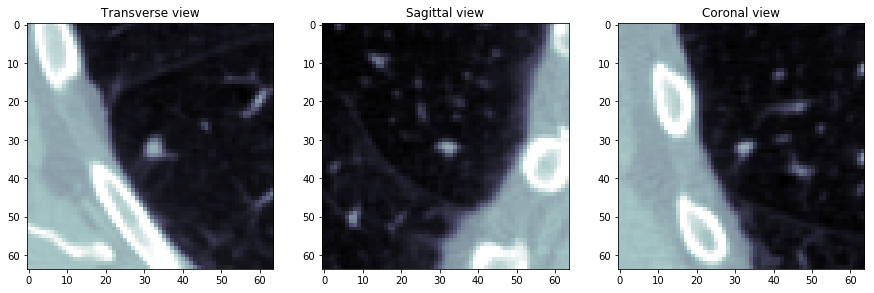

 12%|█▎        | 1/8 [00:35<04:07, 35.30s/it]

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
Class = 1


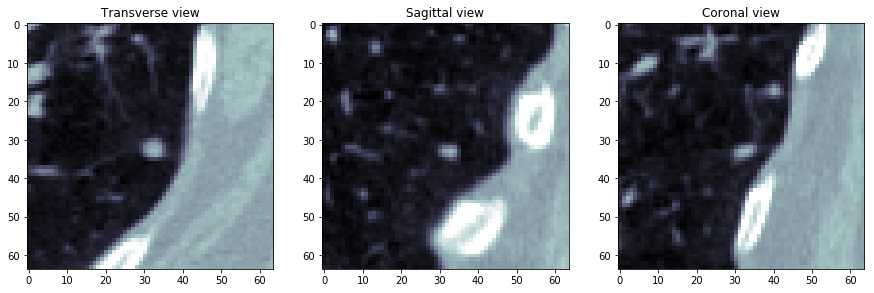

 25%|██▌       | 2/8 [01:06<03:18, 33.17s/it]

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
Class = 1


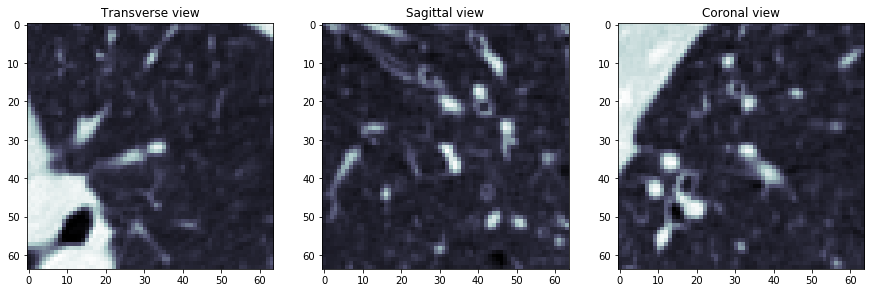

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
Class = 1


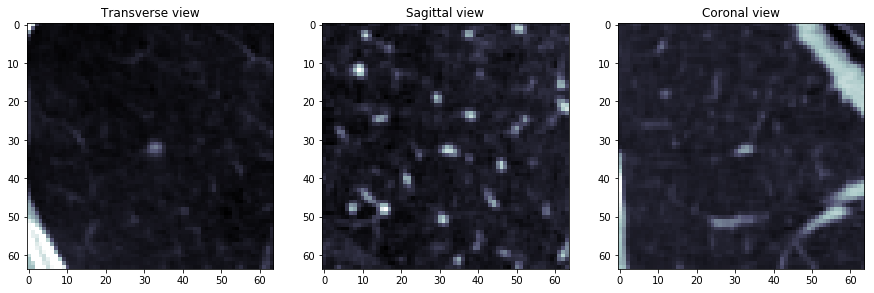

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
Class = 1


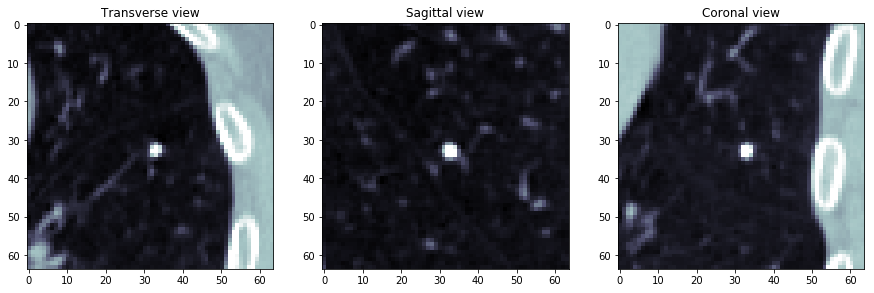

 50%|█████     | 4/8 [02:19<02:19, 34.96s/it]

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
Class = 1


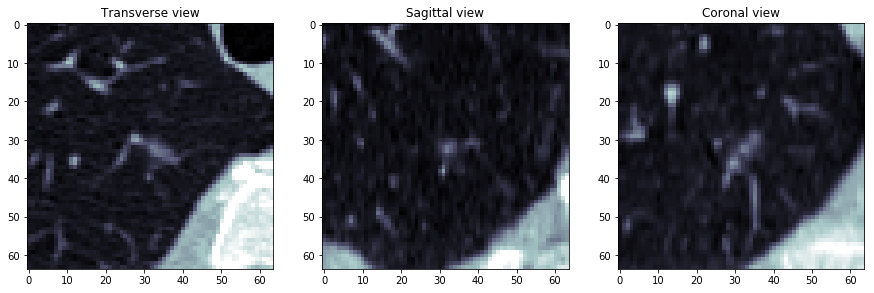

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
Class = 1


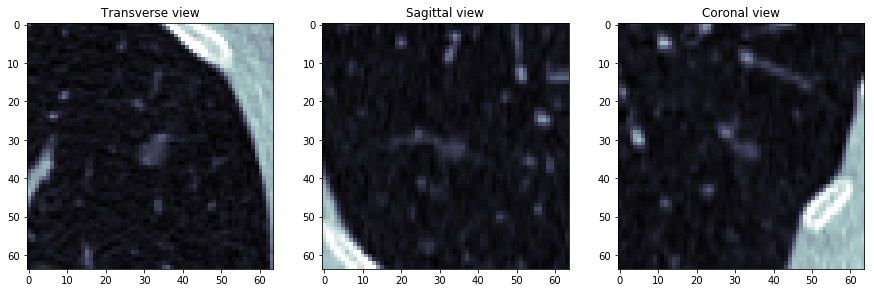

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
Class = 1


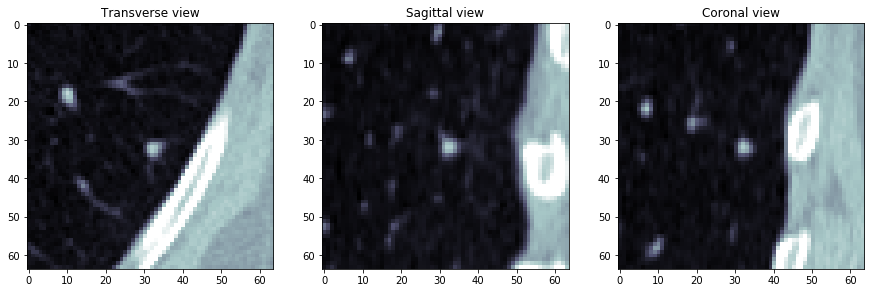

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
Class = 1


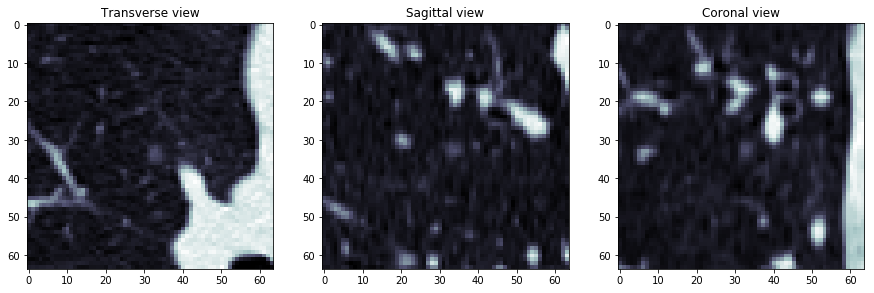

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
Class = 1


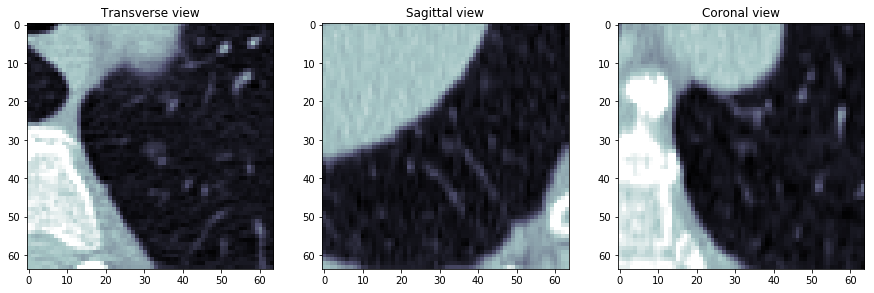

 62%|██████▎   | 5/8 [02:45<01:39, 33.04s/it]

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630.mhd
Class = 1


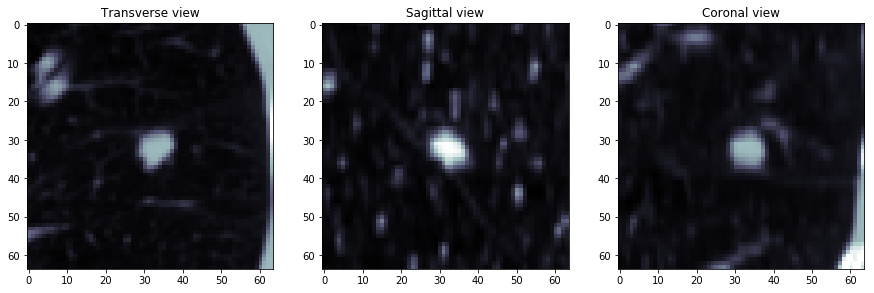

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630.mhd
Class = 1


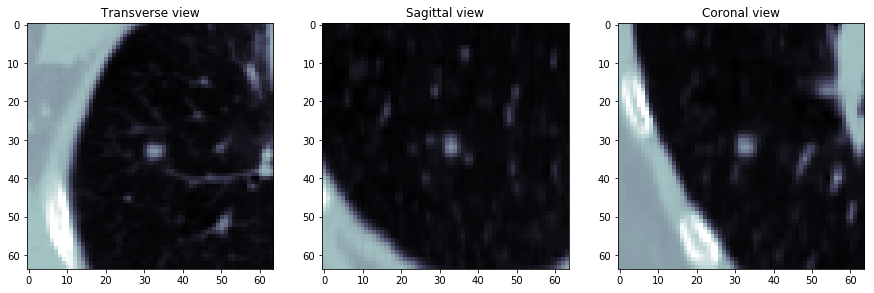

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630.mhd
Class = 1


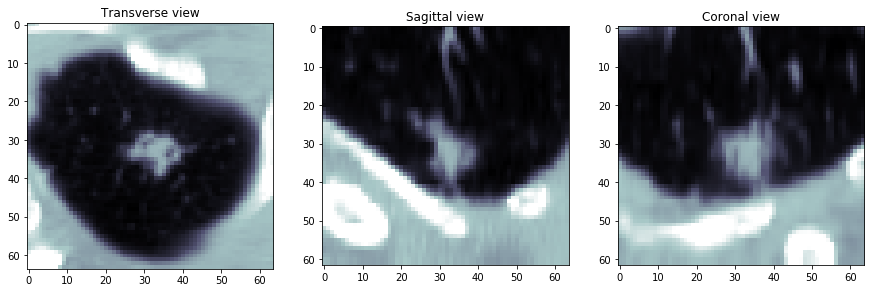

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630.mhd
Class = 1


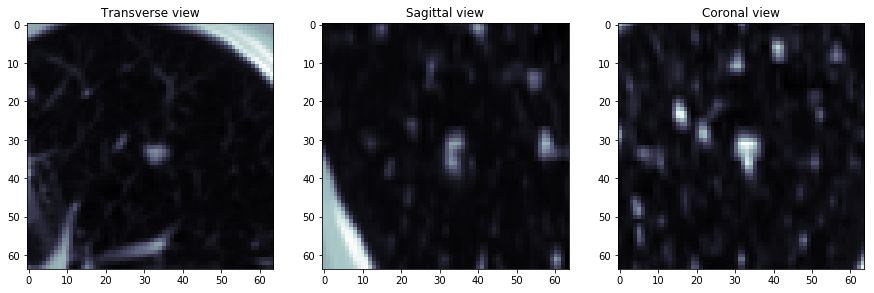

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630.mhd
Class = 1


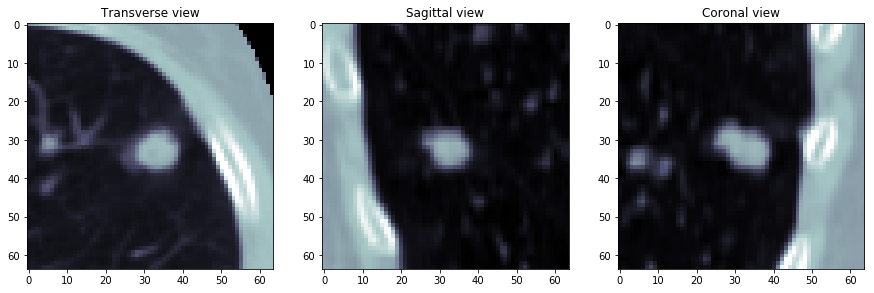

 75%|███████▌  | 6/8 [02:54<00:58, 29.13s/it]

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
Class = 1


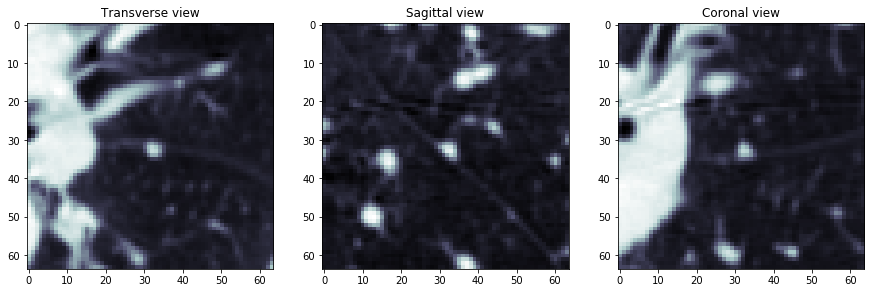

/home/kyle/datasets/luna16_DATA/subset-sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
Class = 1


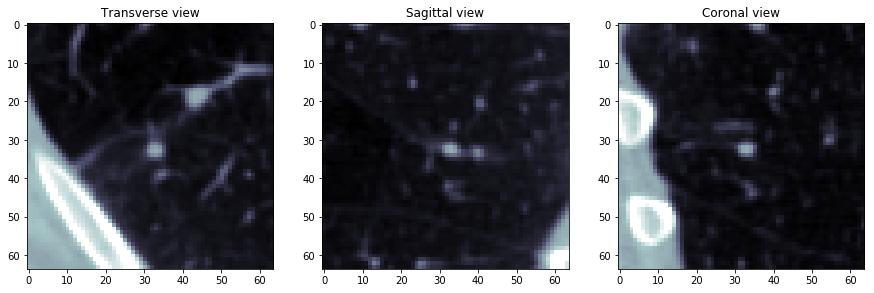

100%|██████████| 8/8 [03:32<00:00, 26.58s/it]


In [27]:
# Looping over the image files

for fcount, img_file in enumerate(tqdm(FILE_LIST)):
    
    base=os.path.basename(img_file)  # Strip the filename out
    seriesuid = os.path.splitext(base)[0]  # Get the filename without the extension
    mini_df = df_node[df_node["seriesuid"] == seriesuid]
    
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        
        '''
        Extracts 2D patches from the 3 planes (transverse, coronal, and sagittal).
        
        The sticking point here is the order of the axes. Numpy is z,y,x and SimpleITK is x,y,z.
        I've found it very difficult to keep the order correct when going back and forth,
        but this code seems to pass the sanity checks.
        '''
        # Load the CT scan (3D .mhd file)
        itk_img = sitk.ReadImage(img_file)  # indices are x,y,z (note the ordering of dimesions)
        
        # Normalize the image spacing so that a voxel is 1x1x1 mm in dimension
        itk_img = normalize_img(itk_img)
       
        # SimpleITK keeps the origin and spacing information for the 3D image volume
        img_array = sitk.GetArrayFromImage(itk_img) # indices are z,y,x (note the ordering of dimesions)
        slice_z, height, width = img_array.shape        
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coords (mm) - Not same as img_array
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coordinates (mm)
        
        for candidate_idx, cur_row in mini_df.iterrows(): # Iterate through all candidates
            
            # This is the real world x,y,z coordinates of possible nodule (in mm)
            candidate_x = cur_row['coordX']
            candidate_y = cur_row['coordY']
            candidate_z = cur_row['coordZ']
            #diam = cur_row['diameter_mm']  # Only defined for true positives
            diam=30
            class_id = cur_row['class']
            
            mask_width = 32 # This is really the half width so window will be double this width
            mask_height = 32 # This is really the half height so window will be double this height
            mask_depth = 32 # This is really the half depth so window will be double this depth
            
            center = np.array([candidate_x, candidate_y, candidate_z])   # candidate center
            voxel_center = np.rint((center-origin)/spacing).astype(int)  # candidate center in voxel space (still x,y,z ordering)
            
            # Calculates the bounding box (and ROI mask) for desired position
            mask, bbox = make_mask(center, diam, voxel_center[2]*spacing[2]+origin[2],
                                   width, height, slice_z, spacing, origin, 
                                   mask_width, mask_height, mask_depth)
                
            # Transverse slice 2D view - Y-X plane
            # Confer with https://en.wikipedia.org/wiki/Anatomical_terms_of_location#Planes
            img_transverse = normalizePlanes(img_array[voxel_center[2], 
                                                       bbox[0][0]:bbox[0][1], 
                                                       bbox[1][0]:bbox[1][1]])
            
            # Sagittal slice 2D view - Z-Y plane
            img_sagittal = normalizePlanes(img_array[bbox[2][0]:bbox[2][1], 
                                                     bbox[0][0]:bbox[0][1], 
                                                     voxel_center[0]])
            
            # Coronal slice 2D view - Z-X plane
            img_coronal = normalizePlanes(img_array[bbox[2][0]:bbox[2][1], 
                                                    voxel_center[1], 
                                                    bbox[1][0]:bbox[1][1]])
               
            if (class_id == 1):
                print(img_file)
                print("Class = {}".format(class_id))
                plt.figure(figsize=(15,15))
                plt.subplot(1,3,1)
                plt.imshow(img_transverse, cmap='bone')
                plt.title('Transverse view')
                plt.subplot(1,3,2)
                plt.imshow(img_sagittal, cmap='bone')
                plt.title('Sagittal view')
                plt.subplot(1,3,3)
                plt.imshow(img_coronal, cmap='bone')
                plt.title('Coronal view')
                plt.show()
            
            imsave(PATCH_DIR 
                   + "class_{}_id_{}_xyz_{}_{}_{}.png".format(
                       class_id,seriesuid,candidate_x, candidate_y, candidate_z),img_transverse)
                

In [22]:
print('Finished')

Finished
